In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/chest_xray.zip" "/content/"

In [3]:
!unzip -q "/content/chest_xray.zip" -d "/content"

In [4]:

import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# Instead of  from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras instead
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:


# labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150


# def get_training_data(data_dir):
#     data = []
#     for label in labels:
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                 # Check if the image was loaded correctly
#                 if img_arr is not None and img_arr.size != 0:
#                     resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
#                     # Reshape the resized_arr to have an explicit channel dimension
#                     resized_arr = resized_arr.reshape(img_size, img_size, 1)
#                     data.append([resized_arr, class_num])
#                 else:
#                     print(f"Skipping invalid image: {os.path.join(path, img)}")
#             except Exception as e:
#                 print(f"Error processing image: {os.path.join(path, img)} - {e}")
#     # Separate images and labels before converting to NumPy arrays
#     X = [item[0] for item in data]
#     y = [item[1] for item in data]

#     return np.array(X), np.array(y)  # Convert to NumPy arrays with appropriate dtypes


# train_X, train_y = get_training_data('../content/chest_xray/train')
# test_X, test_y = get_training_data('../content/chest_xray/test')  # You probably want to use the test set here
# val_X, val_y = get_training_data('../content/chest_xray/val')

Skipping invalid image: ../content/chest_xray/train/PNEUMONIA/.DS_Store
Skipping invalid image: ../content/chest_xray/train/NORMAL/.DS_Store
Skipping invalid image: ../content/chest_xray/val/PNEUMONIA/.DS_Store
Skipping invalid image: ../content/chest_xray/val/NORMAL/.DS_Store


In [6]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None and img_arr.size != 0:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
                else:
                    print(f"Skipping invalid image: {os.path.join(path, img)}")
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [18]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')  # You probably want to use the test set here
val = get_training_data('/content/chest_xray/val')

Skipping invalid image: /content/chest_xray/train/PNEUMONIA/.DS_Store
Skipping invalid image: /content/chest_xray/train/NORMAL/.DS_Store
Skipping invalid image: /content/chest_xray/val/PNEUMONIA/.DS_Store
Skipping invalid image: /content/chest_xray/val/NORMAL/.DS_Store


In [29]:
# prompt: in val add all the images of test in it

val = np.concatenate((val, test))


<Axes: xlabel='count'>

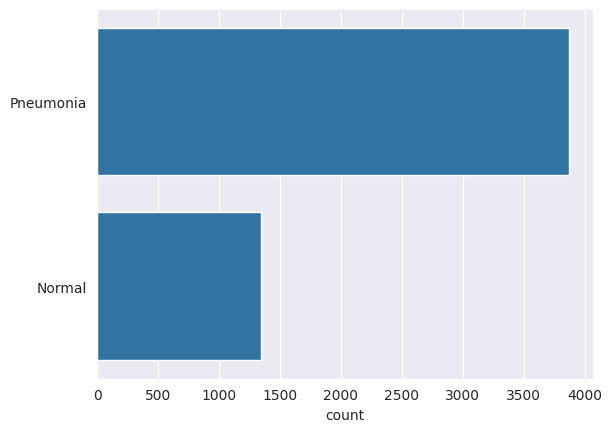

In [30]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

In [31]:
# prompt: print size of test train valid with percentage

print("Train size:", len(train), f"({len(train) / (len(train) + len(test) + len(val)) * 100:.2f}%)")
print("Test size:", len(test), f"({len(test) / (len(train) + len(test) + len(val)) * 100:.2f}%)")
print("Validation size:", len(val), f"({len(val) / (len(train) + len(test) + len(val)) * 100:.2f}%)")


Train size: 5216 (80.49%)
Test size: 624 (9.63%)
Validation size: 640 (9.88%)


Text(0.5, 1.0, 'NORMAL')

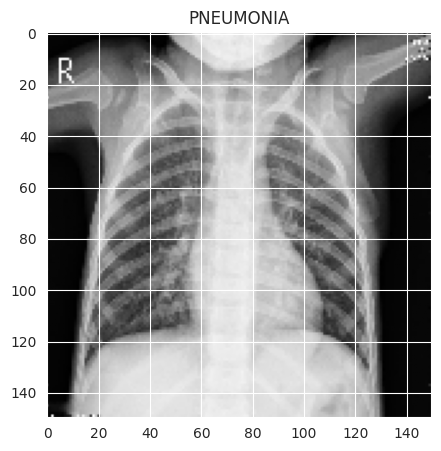

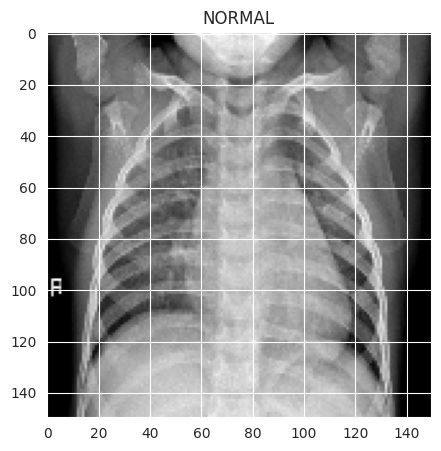

In [32]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])


In [33]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [34]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [35]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [56]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on your training data
datagen.fit(x_train)

In [58]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

# Block 2
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

# Block 3
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Dropout(0.2))
# Block 4
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

# Block 5 (optional deeper layer)
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Dropout(0.3))
# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,849,281 (18.50 MB)

 Trainable params: 4,847,297 (18.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [59]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=8, verbose=1, restore_best_weights=True)

# Merge the callbacks into a list
callbacks_list = [learning_rate_reduction, checkpoint, early_stopping]

# Compile the model with the callback list
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and callbacks
history = model.fit(datagen.flow(x_train, y_train, batch_size=16), epochs=25,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)  # Use your existing callbacks_list

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7923 - loss: 1.5845
Epoch 1: val_accuracy improved from -inf to 0.62187, saving model to best_model.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7924 - loss: 1.5816 - val_accuracy: 0.6219 - val_loss: 61.9565 - learning_rate: 0.0010
Epoch 2/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8760 - loss: 0.2958
Epoch 2: val_accuracy did not improve from 0.62187
326/326 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8760 - loss: 0.2958 - val_accuracy: 0.6219 - val_loss: 7.8380 - learning_rate: 0.0010
Epoch 3/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9173 - loss: 0.2229
Epoch 3: val_accuracy improved from 0.62187 to 0.72344, saving model to best_model.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9173 - loss: 0.2230 - val_accuracy: 0.7234 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 4/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9207 - loss: 0.2212
Epoch 4

Test Loss: 0.2340
Test Accuracy: 0.9311


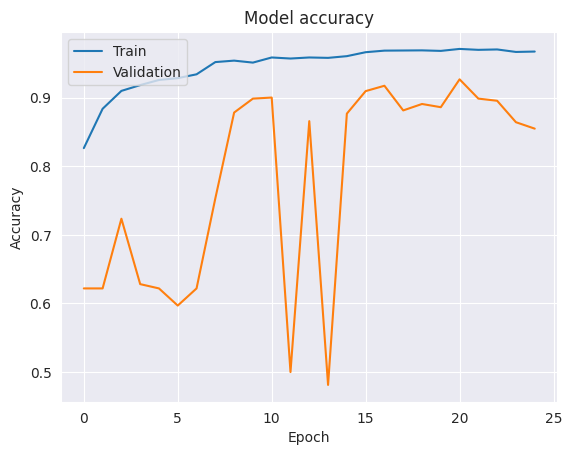

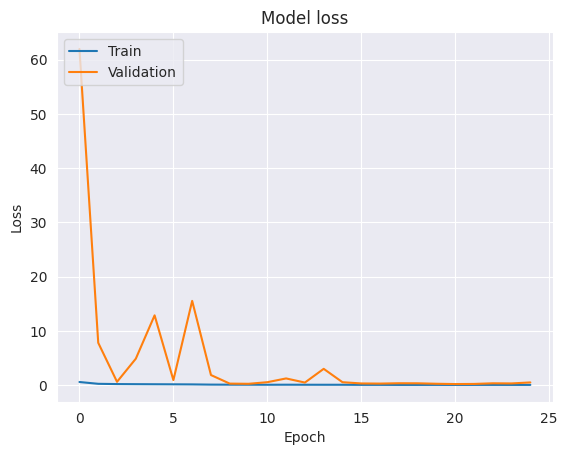

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Accuracy: 0.9311
Precision: 0.9170
Recall: 0.8974
F1 Score: 0.9071
ROC AUC: 0.9722
Confusion Matrix:
[[371  19]
 [ 24 210]]


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 1. Evaluate on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Plot learning curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 3. Analyze predictions and metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

In [62]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9467 - loss: 0.1835
Loss of the model is -  0.2339613437652588
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9467 - loss: 0.1835
Accuracy of the model is -  93.10897588729858 %
